# IST 664 - Project

## Imports

In [95]:
import numpy as np
import pandas as pd
import re
import json
import time
import datetime

import itertools
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from spellchecker import SpellChecker
from joblib import dump, load

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jeet\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jeet\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Loading Datasets

In [2]:
%%time
data = "project_dataset/Cell_Phones_and_Accessories_5.json.gz"
df_phones = pd.read_json(data, lines = True, compression = "gzip")
df_phones.head()

Wall time: 13.2 s


In [3]:
%%time
data = "project_dataset/Grocery_and_Gourmet_Food_5.json.gz"
df_grocery = pd.read_json(data, lines = True, compression = "gzip")
df_grocery.head()

Wall time: 12.2 s


In [4]:
%%time
data = "project_dataset/Movies_and_TV_5.json.gz"
df_movies = pd.read_json(data, lines = True, compression = "gzip")
df_movies.head()

Wall time: 1min 24s


In [10]:
df_phones.shape

(1128437, 12)

In [11]:
df_grocery.shape

(1143860, 12)

In [12]:
df_movies.shape

(3410019, 12)

## Combining Datasets

In [14]:
df = df_phones.append(df_grocery)
df = df.append(df_movies)
df.head()

,asin,image,overall,reviewText,reviewTime,reviewerID,reviewerName,style,summary,unixReviewTime,verified,vote
0,7508492919,NaN,5,Looks even better in person. Be careful to not...,"08 4, 2014",A24E3SXTC62LJI,Claudia Valdivia,{'Color:': ' Bling'},Can't stop won't stop looking at it,1407110400,True,NaN
1,7508492919,NaN,5,When you don't want to spend a whole lot of ca...,"02 12, 2014",A269FLZCB4GIPV,sarah ponce,NaN,1,1392163200,True,NaN
2,7508492919,NaN,3,"so the case came on time, i love the design. I...","02 8, 2014",AB6CHQWHZW4TV,Kai,NaN,Its okay,1391817600,True,NaN
3,7508492919,NaN,2,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,"02 4, 2014",A1M117A53LEI8,Sharon Williams,NaN,CASE,1391472000,True,NaN
4,7508492919,NaN,4,"I liked it because it was cute, but the studs ...","02 3, 2014",A272DUT8M88ZS8,Bella Rodriguez,NaN,Cute!,1391385600,True,NaN


In [15]:
df.shape

(5682316, 12)

In [16]:
#Removing rows with missing values from reviewText 
df = df[df.reviewText.notnull()].reindex()

In [ ]:
#Removing rows associated with non-verified reviews
df = df[df.verified].reindex()

In [17]:
df.shape

(5679580, 12)

In [18]:
#Defining of X and y (class to predict)
X = df.reviewText.values
y = df.overall.values > 3

In [19]:
emoticon_repl = {
    # positive emoticons
    r":-?d+": " good ", # :D, :-D, :DD, ecc. in lower case
    r":[- ]?\)+": " good ", # :-), :), :-)), :)), ecc
    r";-?\)+": " good ", # ;). ;)). ;-), ecc.
    r"\(+-?:": " good ", # (:, (-:, ecc.
    r"=\)+" : " good ",
    r"\b<3\b" : " good ",    
    # negative emoticons
    r"[\s\r\t\n]+:/+": " bad ", # :/
    r":\\+": " bad ", # :\
    r"[\s\r\t\n]+\)-?:": " bad ",  # ):, )):, )-:, ecc.
    r":-?\(+": " bad ", # :(, :-(, :((, ecc.
    r"[\s\t\r\n]+d+-?:": " bad "
}

In [20]:
# Check if re is present in some review
def check_presence(regex, stop = 1, verbose = True):
    j = 0
    tv = False
    for i in range(len(X)):
        if re.search(regex, X[i].lower()):
            tv = True
            j += 1
            sentiment = "positive" if y[i] else "negative"
            if verbose:
                print("Review #",i)
                print("Sentiment: {}".format(sentiment))
                print("Occurrences of the regex {} :".format(regex), re.findall(regex, X[i].lower()))
                print("Review text:", X[i]+"\n")
            if j == stop:
                break
    return tv

In [21]:
check_presence(r":-?d+")

Review # 3248
Sentiment: positive
Occurrences of the regex :-?d+ : [':d']
Review text: Great!!! Love to use this to change my voice to a squeaker :D



True

In [22]:
check_presence(r"[\s\r\t\n]+\)-?:")

Review # 94758
Sentiment: negative
Occurrences of the regex [\s\r\t\n]+\)-?: : [' ):']
Review text: This product was fantastic when I first got it. I could easily transfer my music from my Macbook Pro to my Samsung Galaxy Tab 2.
My SD card became corrupted (not related to the product) so I had to go put everything back on my tablet and this adapter no longer works. ): It seems like it's too loose for the input.



True

In [23]:
#Function for checking if an emoticon corresponds to the expected sentiment
from scipy.stats import norm
from scipy.stats import chi2_contingency

In [24]:
def check_sentiment(regex):
    pos = 0
    neg = 0
    lx = len(X)
    
    for i in range(lx):
        if re.search(regex, X[i].lower()):
            if y[i]:
                pos += 1
            else:
                neg += 1
                
    tot_reviews = len(y)
    tot_pos = np.sum(y)
    tot_neg = tot_reviews - tot_pos
                
    n1 = pos + neg
    n2 = tot_reviews - n1
    
    if emoticon_repl[regex] in [" good ", " great "]:
        test1 = pos
        test2 = tot_pos - pos
        sent = "positive"        
    else:
        test1 = neg
        test2 = tot_neg - neg
        sent = "negative"

        
    # One tailed proportion test
    # https://online.stat.psu.edu/stat414/node/268/
    p1 = test1/n1
    p2 = test2/n2
    p = (test1 + test2)/(n1+n2)
    num = (p1-p2)
    denom = np.sqrt(p*(1-p)*(1/n1 + 1/n2))
    prop_zstat = num/denom
    prop_pvalue = norm.sf(abs(prop_zstat))
    
    
    # Chisq test
    obs = np.array([[pos, neg],
                    [(tot_pos-pos), (tot_neg-neg)]])
    chi_zstat, chi_pvalue, _, _ = chi2_contingency(obs)
    
    cont_table = "\n{0:>16s} | No {0}\nPos {1:12d} | {2:d}\nNeg {3:12d} | {4:d}\n"\
    .format(regex, pos,tot_pos-pos, neg, tot_neg-neg)
    
    #"Positive reviews containing regex {} : {}; p1 = {:.2f}\n".format(regex, pos, pos/n1) + \
    #"Positive reviews not containing regex {} : {}; p2 = {:.2f}\n".format(regex, tot_pos-pos, (tot_pos-pos)/n2) + \
    print("Contingency table:\n" + \
          cont_table + \
          "\np1: #({} reviews) / #(reviews containing {}) = {:.2f}\n".format(sent, regex, test1/n1) + \
          "p2: #({} reviews) / #(reviews not containing {}) = {:.2f}\n".format(sent, regex, test2/n2) + \
          "H_0 proportion test: p1 - p2 <= 0\n" + \
          "Proportion test p-value = {}\n".format(prop_pvalue) + \
          
          "Chisq test p-value = {}".format(chi_pvalue))

In [25]:
#testing the significance of difference for each emoticon in the dictionary
check_sentiment(r":[- ]?\)+")

Contingency table:

       :[- ]?\)+ | No :[- ]?\)+
Pos        42102 | 4512750
Neg         3279 | 1121449

p1: #(positive reviews) / #(reviews containing :[- ]?\)+) = 0.93
p2: #(positive reviews) / #(reviews not containing :[- ]?\)+) = 0.80
H_0 proportion test: p1 - p2 <= 0
Proportion test p-value = 0.0
Chisq test p-value = 0.0


#### There are more negative reviews containing "):" and similar than positive ones, even though the difference is not that big

In [26]:
check_sentiment(r"[\s\r\t\n]+\)-?:")

Contingency table:

[\s\r\t\n]+\)-?: | No [\s\r\t\n]+\)-?:
Pos           34 | 4554818
Neg           35 | 1124693

p1: #(negative reviews) / #(reviews containing [\s\r\t\n]+\)-?:) = 0.51
p2: #(negative reviews) / #(reviews not containing [\s\r\t\n]+\)-?:) = 0.20
H_0 proportion test: p1 - p2 <= 0
Proportion test p-value = 5.7676530299120395e-11
Chisq test p-value = 3.0882817392485917e-10


#### The emoticon is very rare, so we delete it from the list

In [27]:
del emoticon_repl[r"[\s\r\t\n]+\)-?:"]

#### The "D:" is very rare, and the difference in proportions is not significant

In [28]:
check_sentiment(r"[\s\t\r\n]+d+-?:")

Contingency table:

[\s\t\r\n]+d+-?: | No [\s\t\r\n]+d+-?:
Pos          108 | 4554744
Neg           84 | 1124644

p1: #(negative reviews) / #(reviews containing [\s\t\r\n]+d+-?:) = 0.44
p2: #(negative reviews) / #(reviews not containing [\s\t\r\n]+d+-?:) = 0.20
H_0 proportion test: p1 - p2 <= 0
Proportion test p-value = 4.1622524314175996e-17
Chisq test p-value = 1.7808873223906437e-16


In [29]:
del emoticon_repl[r"[\s\t\r\n]+d+-?:"]

### Slang and abbreviations/acronyms Dictionary
 

In [30]:
#Manual definition of dictionary
slang_repl = {
    "tbh" : "to be honest", "afaik" : "as far as i know",
    "ama" : "ask me anything", "b4" : "before",
    r"baa+d" : " bad ", "brb" : "be right back",
    "btaim" : "be that as it may", "bts" : "behind the scenes",
    "btw" : "by the way", "dyk" : "did you know",
    "eli5" : "explain like i am five", "fomo" : "fear of missing out",
    "ftfy" : "fixed that for you", "ftw" : "for the win",
    "fyi" : "for your information", "g2g" : "got to go",
    r"gooo+d": " good ", "gtg" : "got to go",
    "gg" : "good game", r"gr8t*": " great ",
    "gtr" : "got to run", "hmb" : "hit me back",
    "hmu" : "hit me up", "hth" : "happy to help",
    "icymi" : "in case you missed it", "idc" : "i do not care",
    "idk" : "i do not know", "ikr" : "i know right",
    "ily" : "i love you", "imho" : "in my humble opinion",
    "imo" : "in my opinion", "irl" : "in real life",
    "jk" : "just kidding", "lmao" : "laughing my ass off",
    "lmk" : "let me know", "lol" : "laughing out loud",
    "mfw" : "my face when", "nbd" : "no big deal",
    "nm" : "not much", "nvm" : "never mind",
    "omw" : "on my way", "op" : "original poster",
    "ppl" : "people", "rofl" : "rolling on the floor laughing",
    "roflmao" : "rolling on the floor laughing my ass off", "smh" : "shaking my head",
    "tbbh" : "to be brutally honest", "tfw" : "that feeling when",
    "til" : "today i learned", "tmi" : "too much information",
    "wbu" : "what about you", "yolo" : "you only live once"  
}

In [57]:
with open('project_dataset/slang_subset_manual.json', 'r') as fid:
    slang_repl_subset = json.load(fid)

In [ ]:
set(slang_repl.keys())-set(slang_repl_subset.keys())

In [59]:
slang_repl = slang_repl_subset

### Contracted forms


In [60]:
#We will be interested in combinations of "not" + other terms and similar
contracted_repl = {
    # casi particolari
    r"won\'t" : "will not", r"won\'" : "will not",
    r"can\'t": "can not", r"shan\'t": "shall not",
    r"shan\'": "shall not", r"ain\'t": "is not",
    r"ain\'": "is not",
    # casi generali
    r"n\'t": " not",
    r"n\'": " not",
    r"\'s": " is",
    r"\'ve": " have", 
    r"\'re": " are", 
    r"\'ll": " will", # Might also be "shall", in any case both will be considered stop words
    r"\'d": " would", # Might also be "had", in any case both will be considered stop words
}

### Complete preprocessing function
 

Lowering the text;
Removing video html part from reviews including a video;
Removing URLs;
Substituting emoticons with associated sentiment;
Translating slang and acronyms;
Expanding contracted forms;
Deleting non-alphanumeric characters (excluding the ones useful for tokenization);
Deleting terms consisting of digits only
Stop words removal and spelling correction are done after tokenization

In [61]:
def preprocess(sent, translate_slang = True):
    
    sent = sent.lower()
    sent = re.sub(r'^<div id="video.*>&nbsp;', '', sent)
    sent = re.sub('https?://[A-Za-z0-9./]+', '', sent)
    
    for k in emoticon_repl:
        sent = re.sub(k, emoticon_repl[k], sent)

    if translate_slang:
        for k in slang_repl:
            sent = re.sub(r"\b"+re.escape(k)+r"\b", slang_repl[k], sent)
            # sent = sent.replace(k, slang_repl[k])
        
    for k in contracted_repl:
        sent = re.sub(k, contracted_repl[k], sent)
    
    sent = re.sub('[/]+', ' ', sent) # word1/word2 to word1 word2
    # Remove non-alphanumeric characters (but not - and _, might be useful for tokenization)
    sent = re.sub('[^A-Za-z0-9-_ ]+', '', sent)

    # Remove words that are digits only
    sent = re.sub('\b\d+\b', '', sent)
    
    return sent

In [68]:
X[1272]

'<div id="video-block-R2V9ODY7BN8VJ2" class="a-section a-spacing-small a-spacing-top-mini video-block"></div><input type="hidden" name="" value="https://images-na.ssl-images-amazon.com/images/I/B1juE9-rP9S.mp4" class="video-url"><input type="hidden" name="" value="https://images-na.ssl-images-amazon.com/images/I/61S9PJpIfhS.png" class="video-slate-img-url">&nbsp;Great little Usb Hub.  7 ports.  3 on each side, 1 on the front.  Powered by AC or usb.  Lights remain on at all times regardless of what are plugged into the ports.  A must buy if you need more usb ports for your comp.  Works on windows 7.  Have had almost a year with zero issues.'

In [69]:
preprocess(X[1272])

'great little usb hub  7 ports  3 on each side 1 on the front  powered by ac or usb  lights remain on at all times regardless of what are plugged into the ports  a must buy if you need more usb ports for your comp  works on windows 7  have had almost a year with zero issues'

In [70]:
X[27]

"crystals fell off as nothing :( that's why I really didn't like it but as soon as I saw it I liked it but the stones"

In [71]:
preprocess(X[27])

'crystals fell off as nothing  bad  that is why i really did not like it but as soon as i saw it i liked it but the stones'

In [72]:
%%time
df["reviewTextPreprocessed"] = df["reviewText"].apply(preprocess)

Wall time: 37min 43s


In [73]:
df["reviewText"].loc[1272]

1272    <div id="video-block-R2V9ODY7BN8VJ2" class="a-...
1272    This is our favorite flavor of all the differe...
1272    One of my favorite comedy shows.  Bob Newhart ...
Name: reviewText, dtype: object

In [74]:
df["reviewTextPreprocessed"].loc[1272]

1272    great little usb hub  7 ports  3 on each side ...
1272    this is our favorite flavor of all the differe...
1272    one of my favorite comedy shows  bob newhart i...
Name: reviewTextPreprocessed, dtype: object

In [75]:
#Deleting rows where reviews are empty after preprocessing
df = df[~df.reviewTextPreprocessed.str.contains(r"^\s*$")]

In [76]:
df.shape

(5679424, 13)

In [77]:
len(X)-len(df)

156

#### 156 reviews empty after preprocessing

In [78]:
#Saving cleaned dataset
df[["reviewTextPreprocessed", "overall", "verified"]].to_csv("project_dataset/preprocessed_dataset.csv", index = False)

In [99]:
%%time
data = "project_dataset/preprocessed_dataset.csv"
df = pd.read_csv(data)
df = df[df.reviewTextPreprocessed.notna()]
df.head()

Wall time: 23.6 s


In [100]:
df.shape

(5679421, 3)

In [102]:
#See proportion of positive (>3) and critical (<=3) reviews
df["positive"] = df.overall > 3
df.groupby("positive").size()

positive
False    1124686
True     4554735
dtype: int64

In [103]:
df.groupby("positive").size()/(df.shape[0])

positive
False    0.198028
True     0.801972
dtype: float64

#### The class to predict is highly unbalanced. We can sample in order to have a balanced class

In [104]:
sample_size = 500000 # needs to be less than the number of observations in the minority class
sample_df = df.groupby('positive').apply(lambda x: x.sample(sample_size))

In [105]:
sample_df = sample_df.reset_index(level=0, drop=True) # remove outer level of multiindex

In [106]:
sample_df.groupby("positive").size()

positive
False    500000
True     500000
dtype: int64

#### Definition of balanced X and y (class to predict). The classification with this choice should be better at predicting sentiment on tweets (which might not be unbalanced in the same way as this dataset)

In [107]:
X = sample_df.reviewTextPreprocessed.values
y = sample_df.positive.values

Defining a list of stopwords.
The next step is the preprocessing needed to obtain a suitable representation of the reviews, which are:
Tokenization
Spelling correction
Stop words removal
(Stemming)
After these operations, the reviews are going to be passed to a vectorizer in order to obtain the final representation for the classifiers.

Stemming can be achieved using two different libraries: NLTK and PyStemmer. PyStemmer is faster, but needs Visual C++ Build Tools installed. Please choose the relevant code you prefer to run 

### Definition of the list of Stop-words


In [108]:
from nltk.corpus import stopwords
stopws = stopwords.words("english")

The list of stop words needs to be preprocessed in the same way as the reviews. We define the dictionaries needed for the preprocessing

In [110]:
emoticon_repl = {
    # positive emoticons
    r":-?d+": " good ", r":[- ]?\)+": " good ", r";-?\)+": " good ", # ;). ;)). ;-), ecc.
    r"\(+-?:": " good ", r"=\)+" : " good ", r"\b<3\b" : " good ",    
    # negative emoticons
    r"[\s\r\t\n]+:/+": " bad ", r":\\+": " bad ", r"[\s\r\t\n]+\)-?:": " bad ",  # ):, )):, )-:, ecc.
    r":-?\(+": " bad ", r"[\s\t\r\n]+d+-?:": " bad "
}

contracted_repl = {
    # casi particolari
    r"won\'t" : "will not", r"won\'" : "will not", r"can\'t": "can not", r"shan\'t": "shall not",
    r"shan\'": "shall not", r"ain\'t": "is not", r"ain\'": "is not",
    # casi generali
    r"n\'t": " not", r"\'t": " not", r"n\'": " not", r"\'s": " is", r"\'ve": " have", 
    r"\'re": " are", 
    r"\'ll": " will", r"\'d": " would",
}

with open('project_dataset/slang_subset_manual.json', 'r') as fid:
    slang_repl = json.load(fid)

In [111]:
def preprocess(sent, translate_slang = True):
    
    sent = sent.lower()
    sent = re.sub(r'^<div id="video.*>&nbsp;', '', sent)
    sent = re.sub('https?://[A-Za-z0-9./]+', '', sent)
    
    for k in emoticon_repl:
        sent = re.sub(k, emoticon_repl[k], sent)

    if translate_slang:
        for k in slang_repl:
            sent = re.sub(r"\b"+re.escape(k)+r"\b", slang_repl[k], sent)
        
    for k in contracted_repl:
        sent = re.sub(k, contracted_repl[k], sent)
    
    sent = re.sub('[/]+', ' ', sent)
    sent = re.sub('[^A-Za-z0-9-_ ]+', '', sent)
    sent = re.sub('\b\d+\b', '', sent)
    
    return sent

In [112]:
prep_stopws = [preprocess(el) for el in stopws]

Words containing "not" are important for our tasks

In [113]:
np.array(prep_stopws[-36:])

array(['ain', 'aren', 'are not', 'couldn', 'could not', 'didn', 'did not',
       'doesn', 'does not', 'hadn', 'had not', 'hasn', 'has not', 'haven',
       'have not', 'isn', 'is not', 'ma', 'mightn', 'might not', 'mustn',
       'must not', 'needn', 'need not', 'shan', 'shall not', 'shouldn',
       'should not', 'wasn', 'was not', 'weren', 'were not', 'won',
       'will not', 'wouldn', 'would not'], dtype='<U10')

In [114]:
prep_stopws = prep_stopws[:-36]

Other words to remove from the stop words

In [116]:
for word in ["not", "very", "don", "do not"]:
    prep_stopws.remove(word)

In [117]:
prep_stopws.extend(["youse", "would"]) # needed for consistency with spell checker

### Tokenization/Spell Correction/StopWordsRemoval/Stemming 

### NLTK 

In [118]:
from nltk.tokenize import word_tokenize
def tokenize_reviews(reviews):
    tokenized_reviews = [word_tokenize(review) for review in reviews]
    return tokenized_reviews

In [119]:
%%time
X_tokenized = tokenize_reviews(X)

Wall time: 9min 10s


In [120]:
def fix_spelling_mistakes(reviews, dist=1):
    spell = SpellChecker(distance=dist)
    reviews_with_right_spell = []
    for review in reviews:
        corrected_review = [spell.correction(word) for word in review]
        reviews_with_right_spell.append(corrected_review)
    return reviews_with_right_spell

In [121]:
%%time
X_spellchecked = fix_spelling_mistakes(X_tokenized)

Wall time: 1h 37min 35s


### Stop words removal 

In [122]:
%%time
X_noStopWords = []
for review in X_spellchecked:
        cleaned_review = [word for word in review if word not in prep_stopws]
        X_noStopWords.append(cleaned_review)

Wall time: 1min 27s


In [123]:
from nltk.stem import PorterStemmer, LancasterStemmer

In [124]:
def stem_reviews(reviews, stemmer_name="Porter"):
    if stemmer_name == "Porter":
        stemmer = PorterStemmer()
    elif stemmer_name == "Lancaster":
        stemmer = LancasterStemmer()
    else:
        raise SystemError
    stemmed_reviews = []
    for review in reviews:
        stemmed_reviews.append([stemmer.stem(word) for word in review])
    return stemmed_reviews

In [125]:
%%time
X_Porter = stem_reviews(X_noStopWords, stemmer_name = "Porter")

Wall time: 11min 36s


In [126]:
%%time
X_Lancaster = stem_reviews(X_noStopWords, stemmer_name = "Lancaster")

Wall time: 10min 30s


### Train-Test split 

In [248]:
from sklearn.model_selection import train_test_split


#### NLTK
Here we are train/test splitting the set of reviews that is already tokenized and stemmed, to be passed to TfidfVectorizer for representation

In [249]:
X_train_Porter, X_test_Porter, y_train, y_test = train_test_split(X_Porter, y,
                                                                  test_size=0.33, random_state=42)
X_train_Lancaster, X_test_Lancaster, y_train, y_test = train_test_split(X_Lancaster, y,
                                                                        test_size=0.33, random_state=42)

### Text Representation

#### NLTK

In [251]:
def rebuild_reviews(reviews):
    rebuilt_reviews = []
    for review in reviews:
        rebuilt_reviews.append(" ".join(review))
    return rebuilt_reviews

In [252]:
X_train_Porter = rebuild_reviews(X_train_Porter)
X_test_Porter = rebuild_reviews(X_test_Porter)
X_train_Lancaster = rebuild_reviews(X_train_Lancaster)
X_test_Lancaster = rebuild_reviews(X_test_Lancaster)

In [253]:
%%time
tfidf_vect_Porter = TfidfVectorizer(min_df= 5, max_features = 50000, ngram_range=(1,2))
X_train_tfidf_Porter = tfidf_vect_Porter.fit_transform(X_train_Porter)

Wall time: 1min 46s


In [254]:
%%time
X_test_tfidf_Porter = tfidf_vect_Porter.transform(X_test_Porter)

Wall time: 23.4 s


In [255]:
%%time
tfidf_vect_Lancaster = TfidfVectorizer(min_df= 5, max_features = 50000, ngram_range=(1,2))
X_train_tfidf_Lancaster = tfidf_vect_Lancaster.fit_transform(X_train_Lancaster)

Wall time: 1min 42s


In [256]:
%%time
X_test_tfidf_Lancaster = tfidf_vect_Lancaster.transform(X_test_Lancaster)

Wall time: 23.1 s


In [258]:
dump(tfidf_vect_Porter, 'joblib_data/tfidf_vect_Porter.joblib')
dump(tfidf_vect_Lancaster, 'joblib_data/tfidf_vect_Lancaster.joblib')

['joblib_data/tfidf_vect_Lancaster.joblib']

#### No stemming

In [304]:
X_train_nostemmer, X_test_nostemmer, y_train, y_test = train_test_split(X, y,
                                                                  test_size=0.33, random_state=42)

In [305]:
%%time
spell = SpellChecker(distance=1)
tfidf_vect_nostemmer = TfidfVectorizer(min_df= 5, max_features = 50000, ngram_range=(1,2),
                                              preprocessor = spell.correction,
                                              stop_words = prep_stopws)
X_train_tfidf_nostemmer = tfidf_vect_nostemmer.fit_transform(X_train_nostemmer)

Wall time: 5min 51s


In [306]:
%%time
X_test_tfidf_nostemmer = tfidf_vect_nostemmer.transform(X_test_nostemmer)

Wall time: 2min 21s


In [307]:
dump(tfidf_vect_nostemmer, 'joblib_data/tfidf_vect_nostemmer.joblib')

['joblib_data/tfidf_vect_nostemmer.joblib']

### Classification

#### NB Classifier

In [310]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix, f1_score, fbeta_score, precision_score, recall_score

In [311]:
def print_top_features(vectorizer, clf, n = 10):
    fnames = vectorizer.get_feature_names()
    top_pos = np.argsort(clf.coef_[0])[-n:]
    top_pos = top_pos[::-1]
    print("Most discriminative features:\n",
          ", ".join(fnames[j] for j in top_pos))

In [312]:
def score_model(clf, X_train, X_test, y_train, y_test, probabilities = True):
    train_score = clf.score(X_train, y_train) # Train Accuracy
    test_score = clf.score(X_test, y_test)    # Test Accuracy
    
    predictions = clf.predict(X_test)

    prec = precision_score(y_test, predictions) # Precision
    rec = recall_score(y_test, predictions) # Recall
    f1 = f1_score(y_test, predictions) # F1
    f2 = fbeta_score(y_test, predictions, 2) # F2
    cm = confusion_matrix(y_test, predictions)
    if probabilities:
        proba = clf.predict_proba(X_test)

        precision, recall, pr_thresholds = precision_recall_curve(y_test, proba[:,1])

        auc_score = auc(recall, precision)

        scores_strings = ["Train Accuracy", "Test Accuracy", "Test Precision",
                          "Test Recall", "F1", "F2", "P/R AUC"]

        scores = [train_score, test_score, prec, rec, f1, f2, auc_score]

        print(("{:20s} {:.5f}\n"*7)[:-1].format(*itertools.chain(*zip(scores_strings, scores))))

        print(classification_report(y_test, predictions, digits=5))

        plt.plot(recall, precision, label='Precision-Recall curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('Precision-Recall Curve: AUC=%0.2f' % auc_score)
        plt.legend(loc="lower left")
        plt.show()
    else:
        scores_strings = ["Train Accuracy", "Test Accuracy", "Test Precision",
                          "Test Recall", "F1", "F2"]

        scores = [train_score, test_score, prec, rec, f1, f2]

        print(("{:20s} {:.5f}\n"*6)[:-1].format(*itertools.chain(*zip(scores_strings, scores))))

        print(classification_report(y_test, predictions, digits=5))

### No Stemmer

In [313]:
%%time
clf = MultinomialNB()
clf.fit(X_train_tfidf_nostemmer, y_train)

Wall time: 279 ms


In [314]:
print_top_features(tfidf_vect_nostemmer, clf, 50)


Most discriminative features:
 great, good, love, movie, not, very, excellent, one, like, product, well, great movie, case, best, phone, loved, nice, really, series, film, very good, time, show, perfect, story, awesome, watch, good movie, price, movies, works, get, much, dvd, enjoyed, see, quality, funny, use, buy, recommend, fun, favorite, little, taste, better, also, first, wonderful, still


In [315]:
%%time
predictions = clf.predict(X_test_tfidf_nostemmer)

Wall time: 96.6 ms


Train Accuracy       0.83949
Test Accuracy        0.83232
Test Precision       0.84450
Test Recall          0.81483
F1                   0.82940
F2                   0.82060
P/R AUC              0.91148
              precision    recall  f1-score   support

       False    0.82096   0.84983   0.83514    164923
        True    0.84450   0.81483   0.82940    165077

   micro avg    0.83232   0.83232   0.83232    330000
   macro avg    0.83273   0.83233   0.83227    330000
weighted avg    0.83274   0.83232   0.83227    330000



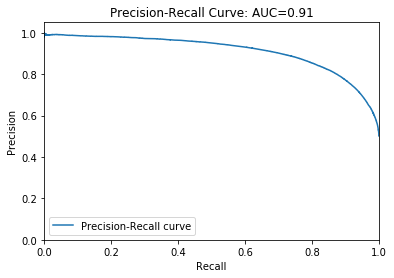

Wall time: 1.74 s


In [316]:
%%time
score_model(clf, X_train_tfidf_nostemmer, X_test_tfidf_nostemmer, y_train, y_test)

In [317]:
dump(clf, 'joblib_data/clf_nb_nostemmer.joblib')

['joblib_data/clf_nb_nostemmer.joblib']

### NLTK

#### Porter

In [318]:
%%time
clf = MultinomialNB()
clf.fit(X_train_tfidf_Porter, y_train)

Wall time: 995 ms


In [319]:
print_top_features(tfidf_vect_Porter, clf, 50)

Most discriminative features:
 great, good, love, movi, not, veri, like, excel, one, watch, product, phone, great movi, case, well, film, enjoy, work, time, show, nice, best, realli, thank, use, seri, stori, veri good, get, perfect, good movi, awesom, price, tast, make, recommend, see, buy, season, look, much, qualiti, funni, wonder, fun, favorit, fit, littl, love movi, better


In [320]:
%%time
predictions = clf.predict(X_test_tfidf_Porter)

Wall time: 455 ms


Train Accuracy       0.83649
Test Accuracy        0.83007
Test Precision       0.84301
Test Recall          0.81142
F1                   0.82691
F2                   0.81754
P/R AUC              0.90935
              precision    recall  f1-score   support

       False    0.81806   0.84875   0.83312    164923
        True    0.84301   0.81142   0.82691    165077

   micro avg    0.83007   0.83007   0.83007    330000
   macro avg    0.83053   0.83008   0.83002    330000
weighted avg    0.83054   0.83007   0.83001    330000



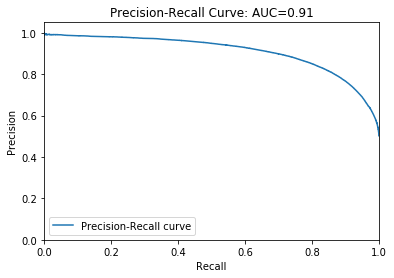

Wall time: 1.32 s


In [321]:
%%time
score_model(clf, X_train_tfidf_Porter, X_test_tfidf_Porter, y_train, y_test)

In [322]:
dump(clf, 'joblib_data/clf_nb_porter.joblib')

['joblib_data/clf_nb_porter.joblib']

#### Lancaster

In [323]:
%%time
clf = MultinomialNB()
clf.fit(X_train_tfidf_Lancaster, y_train)

Wall time: 778 ms


In [324]:
print_top_features(tfidf_vect_Lancaster, clf, 50)

Most discriminative features:
 gre, good, lov, movy, not, very, excel, lik, on, watch, produc, real, phon, gre movy, cas, us, film, enjoy, wel, work, tim, act, nic, show, perfect, best, sery, thank, story, very good, get, good movy, awesom, ev, pric, tast, mak, recommend, see, buy, protect, season, look, much, funny, charg, qual, wond, fun, fit


In [325]:
%%time
predictions = clf.predict(X_test_tfidf_Lancaster)

Wall time: 387 ms


Train Accuracy       0.83452
Test Accuracy        0.82813
Test Precision       0.84209
Test Recall          0.80794
F1                   0.82466
F2                   0.81454
P/R AUC              0.90779
              precision    recall  f1-score   support

       False    0.81526   0.84835   0.83147    164923
        True    0.84209   0.80794   0.82466    165077

   micro avg    0.82813   0.82813   0.82813    330000
   macro avg    0.82867   0.82814   0.82807    330000
weighted avg    0.82868   0.82813   0.82806    330000



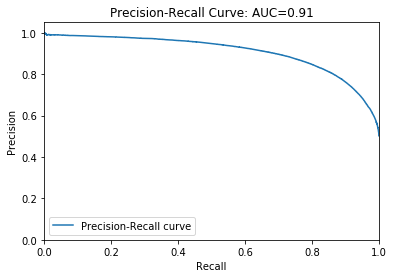

Wall time: 1.31 s


In [326]:
%%time
score_model(clf, X_train_tfidf_Lancaster, X_test_tfidf_Lancaster, y_train, y_test)

In [327]:
dump(clf, 'joblib_data/clf_nb_lancaster.joblib')

['joblib_data/clf_nb_lancaster.joblib']

### Random Forest

In [328]:
from sklearn.ensemble import RandomForestClassifier

#### No stemmer

In [ ]:
%%time
clf = RandomForestClassifier(n_estimators=40, random_state=42, n_jobs=-1)
clf.fit(X_train_tfidf_nostemmer, y_train)

In [ ]:
%%time
predictions = clf.predict(X_test_tfidf_nostemmer)

In [ ]:
score_model(clf, X_train_tfidf_nostemmer, X_test_tfidf_nostemmer, y_train, y_test)
dump(clf, "joblib_data/clf_random_forest_nostemmer.joblib")